### Домашнее задание 1 

<details>
  <summary>Формулировка</summary>

1. Загрузите датасет артефактов вредоносного ПО, хранящихся в памяти - cybersequrity.csv
2. Подготовьте данные к обучению - **1 балл**
    - Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используйте столбец `Class` - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО).
    - **hint**: для ускорения сходимости и стабилизации обучения можно стандартизировать входные признаки, например, с помощью `StandardScaler`
    - Создайте объекты для работы с данными в PyTorch - `Dataset` и `DataLoader` для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, `batch_size`.
3. Реализуйте класс бейзлайновой нейросетевой модели (MLP) для решения задачи - **2 балла**
    - Определите оптимальное количество `Linear` слоев в структуре и их размерности.
    - Подберите оптимальные для задачи функции активации - `ReLU`, `Sigmoid`, `Tanh`, `LeakyReLU`...
    - Реализуйте логику прохождения данных по сети в методе `forward`
    - Cоздайте объект модели, реализуйте перевод модели на gpu
4. Напишите код цикла обучения - train-loop и валидации - eval-loop. В процессе обучения сохраняйте и визуализируйте на графике динамику функции потерь на тренировочной и валидационной выборках - **1 балл**
5. Обучите модель и проверьте ее качество - **1 балл**
    - Выберите оптимизатор, в качестве функции потерь используйте `nn.BCELoss`
    - Запустите обучение, постарайтесь подобрать оптимальные скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val
    - Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации - `classification_report`
6. Улучшите архитектуру модели из пункта 3 и добейтесь увеличения качества - **3 балла**
    - Попробуйте добавить слои `BatchNorm1d` и `Dropout` - поэкспериментируйте с их "расположением" в сети, напишите свои выводы о целесообразности их добавления в модель, оптимальном расположении, влиянии на качество/сходимость обучения. При использовании слоя `Dropout` - определите экспериментально или обоснуйте теоретически оптимальное значение параметра `p`.
    - Обучите улучшенную модель и проверьте ее качество (при необходимости измените гиперпараметры обучения - `batch_size`, скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val и архитектуру модели)

**Общее**

- Принимаемые решения обоснованы (почему выбрана определенная архитектура/гиперпараметр/оптимизатор/проеобразование и т.п.) - **1 балл**
- Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**

**Формат сдачи ДЗ**

- Создать отедльный репозиторий (если еще не создавали)
- Выдать доступ в репозиторий своему ментору и pacifikus (распределение по менторам и их ники на гитхабе есть в [таблице](https://docs.google.com/spreadsheets/d/1qneC-kHlNzgkCzRoGA9dgUbDthyQd-FA3GhvLCMQY_M/edit?usp=sharing)
- Каждая домашняя работа – PR в отдельную ветку **hw_n**, где **n** - номер домашней работы
- Добавить ментора и pacifikus в reviewers
- Дождаться ревью, если все ок – мержим в main
- Если не ок – вносим исправления и снова отправляем на ревью

</details>

In [1]:
# библиотеки
import os
import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
from collections import defaultdict

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

### Шаг 1

<details>
  <summary>Формулировка</summary>
  
Загрузите датасет артефактов вредоносного ПО, хранящихся в памяти - cybersequrity.csv
</details>


In [2]:
data = pd.read_csv('../data/cybersequrity.csv')
# посмотрим на данные
data.head()

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   svcscan.fs_drivers                      10000 non-null  int64  
 1   callbacks.ngeneric                      10000 non-null  int64  
 2   psxview.not_in_eprocess_pool_false_avg  10000 non-null  float64
 3   psxview.not_in_eprocess_pool            10000 non-null  int64  
 4   callbacks.nanonymous                    10000 non-null  int64  
 5   psxview.not_in_session                  10000 non-null  int64  
 6   psxview.not_in_pslist                   10000 non-null  int64  
 7   psxview.not_in_pspcid_list              10000 non-null  int64  
 8   psxview.not_in_ethread_pool             10000 non-null  int64  
 9   psxview.not_in_csrss_handles            10000 non-null  int64  
 10  psxview.not_in_pslist_false_avg         10000 non-null  flo

In [4]:
data.describe()

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,25.995400,7.999800,0.000069,0.001700,0.000800,3.859000,1.859300,1.85880,2.299500,6.301900,0.040579,0.040569,8.290700,0.047741,0.087565,0.509600
std,0.210198,0.014141,0.001133,0.041198,0.028274,3.016625,3.016623,3.01645,4.827249,4.828653,0.057255,0.057253,4.945568,0.067768,0.054770,0.499933
min,11.000000,7.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,0.000000,4.000000,0.000000,0.000000,4.000000,0.000000,0.011834,0.000000
25%,26.000000,8.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,0.000000,4.000000,0.000000,0.000000,6.000000,0.000000,0.048780,0.000000
50%,26.000000,8.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,1.000000,5.000000,0.020997,0.020997,7.000000,0.023256,0.066667,1.000000
75%,26.000000,8.000000,0.000000,0.000000,0.000000,5.000000,3.000000,3.00000,3.000000,7.000000,0.068182,0.068182,9.000000,0.071429,0.113636,1.000000
max,26.000000,8.000000,0.027778,1.000000,1.000000,37.000000,35.000000,35.00000,139.000000,143.000000,0.500000,0.500000,145.000000,0.771084,0.528571,1.000000


In [5]:
# посмотрим на целевую переменную и ее сбалансированность (столбец Class - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО)
print(data['Class'].value_counts())

print('__' * 22)
# проверим наличие пропущенных значений
print(data.isnull().sum())

Class
1    5096
0    4904
Name: count, dtype: int64
____________________________________________
svcscan.fs_drivers                        0
callbacks.ngeneric                        0
psxview.not_in_eprocess_pool_false_avg    0
psxview.not_in_eprocess_pool              0
callbacks.nanonymous                      0
psxview.not_in_session                    0
psxview.not_in_pslist                     0
psxview.not_in_pspcid_list                0
psxview.not_in_ethread_pool               0
psxview.not_in_csrss_handles              0
psxview.not_in_pslist_false_avg           0
psxview.not_in_pspcid_list_false_avg      0
psxview.not_in_deskthrd                   0
psxview.not_in_ethread_pool_false_avg     0
psxview.not_in_session_false_avg          0
Class                                     0
dtype: int64


In [6]:
# установка всевозможных random seed
def set_seed(seed: int = 21) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(21)

Random seed set as 21


### Шаг 2

<details>
  <summary>Формулировка</summary>

2. Подготовьте данные к обучению - **1 балл**
    - Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используйте столбец `Class` - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО).
    - **hint**: для ускорения сходимости и стабилизации обучения можно стандартизировать входные признаки, например, с помощью `StandardScaler`
    - Создайте объекты для работы с данными в PyTorch - `Dataset` и `DataLoader` для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, `batch_size`.

</details>


#### Разбиение данных и стандартизация StandardScaler

In [7]:
# Убираем целевой столбец из данных и разделяем данные на признаки и целевую переменную
X = data.drop(columns=['Class'])  
y = data['Class']

# Разделяем данные на обучающую, тестовую и валидационную выборки 60/20/20
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=21)

# Стандартизация: только по обучающим данным
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)     # Fit на обучающей выборке
X_val = scaler.transform(X_val)             # Transform на валидационной выборке
X_test = scaler.transform(X_test)           # Transform на тестовой выборке

X_train.shape, X_val.shape, X_test.shape

((6000, 15), (2000, 15), (2000, 15))

#### Подготовка данных для работы в PyTorch - Обертка для данных

(Dataset и DataLoader для обучающей, валидационной и тестовой выборок. Выбор оптимального batch_size)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])  
    
# Создаем объекты Dataset
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Оптимальный batch_size (на мой взгляд лучше взять что-то небольшое)
batch_size = 64

# Создаем DataLoader для каждой выборки
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Пример: Проходимся по одному батчу из обучающей выборки
for batch_features, batch_targets in train_dataloader:
    print("Batch features shape:", batch_features.shape)
    print("Batch targets shape:", batch_targets.shape)
    break

Batch features shape: torch.Size([64, 15])
Batch targets shape: torch.Size([64, 1])


### Шаг 3 - Создание архитектуры модели MLP
<details>
  <summary>Формулировка</summary>

3. Реализуйте класс бейзлайновой нейросетевой модели (MLP) для решения задачи - **2 балла**
    - Определите оптимальное количество `Linear` слоев в структуре и их размерности.
    - Подберите оптимальные для задачи функции активации - `ReLU`, `Sigmoid`, `Tanh`, `LeakyReLU`...
    - Реализуйте логику прохождения данных по сети в методе `forward`
    - Cоздайте объект модели, реализуйте перевод модели на gpu

</details>

##### Обоснование выбора функций активации и архитектуры модели

1. **Функции активации**:
   - `ReLU` используется для скрытых слоев, так как она проста, эффективна, быстро сходится и хорошо справляется с проблемой градиентного затухания.
   - `Sigmoid` применяется на выходе модели, так как задача бинарной классификации требует вероятностного выхода в диапазоне [0, 1] а у нас как раз такая задача для определения вредоносного ПО.

2. **Количество слоев**:
   - Выбрано 3 скрытых слоя для достижения баланса между выразительной способностью модели и снижением риска переобучения (и просто на пробу как оптимальное).

3. **Размерности скрытых слоев**:
   - Размерности скрытых слоев выбраны как 128 → 64 → 32, чтобы постепенно уменьшать количество параметров и аггрегировать информацию, сохраняя ключевые признаки.
   - Начальное значение 128 для первого слоя выбрано для эффективной обработки 15 входных признаков и извлечения высокоуровневых представлений.

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, activation_function=nn.ReLU()):
        super(MLP, self).__init__()
        
        # Создаем слои
        layers = []
        prev_size = input_size
        
        # Добавляем скрытые слои
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(activation_function)
            prev_size = hidden_size
        
        # Выходной слой
        layers.append(nn.Linear(prev_size, 1))
        # Sigmoid для бинарной классификации
        layers.append(nn.Sigmoid()) 
        
        # Объединяем слои в Sequential
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
input_size = X_train.shape[1]
hidden_sizes=[32, 16, 8]

model = MLP(input_size, hidden_sizes, activation_function=nn.ReLU())
model

MLP(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [11]:
# Переводим модель на GPU (если доступен)
if torch.backends.mps.is_available():
    device = torch.device("mps") 
    print("MPS (Metal) доступен и используется!")
else:
    device = torch.device("cpu")
    print("MPS недоступен, используется CPU")
   
# Переводим модель на устройство mps (ускорение на GPU через Metal Performance Shaders на macOS)
model = model.to(device)

MPS (Metal) доступен и используется!


### Шаг 4 - Train-loop & Eval-loop
<details>
  <summary>Формулировка</summary>

4. Напишите код цикла обучения - train-loop и валидации - eval-loop. В процессе обучения сохраняйте и визуализируйте на графике динамику функции потерь на тренировочной и валидационной выборках - **1 балл**

</details>

In [12]:
# Функция для обучения модели
def train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=100, eval_freq=10):
    train_loss_history, eval_loss_history = [], []
    train_f1_history, eval_f1_history = [], []
    global_step = 0

    for epoch in tqdm(range(num_epochs), desc="Epochs"):  # Прогресс-бар для эпох
        model.train()  # Переводим модель в режим обучения
        
        # Прогресс-бар для батчей внутри эпохи
        batch_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        for batch_X, target in batch_progress:
            # Перенос данных на устройство (GPU/CPU)
            batch_X, target = batch_X.to(device), target.to(device)
            
            # Обнуляем градиенты
            optimizer.zero_grad()
            
            # Прямой проход
            log_probs = model(batch_X)
            loss = loss_function(log_probs.squeeze(1), target.squeeze(1).float())
            
            # Обратный проход и обновление весов
            loss.backward()
            optimizer.step()

            # Вычисляем предсказания и F1-score
            preds = (log_probs >= 0.5).int().cpu().tolist()
            f1 = f1_score(preds, target.cpu().numpy().tolist())

            # Сохраняем потери и F1-score
            train_loss_history.append((global_step, loss.item()))
            train_f1_history.append((global_step, f1))

            # Валидация
            if global_step % eval_freq == 0:
                val_loss, val_f1 = evaluate(model, val_loader, loss_function, device)
                eval_loss_history.append((global_step, val_loss))
                eval_f1_history.append((global_step, val_f1))
                model.train()  # Возвращаем модель в режим обучения
                

            # Визуализация каждые 250 шагов
            if global_step % 250 == 0:
                clear_output(True)

                plt.figure(figsize=(15, 5))

                # График потерь
                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()
                plt.title('Loss over Steps')

                # График F1-score
                plt.subplot(122)
                plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
                if len(eval_f1_history):
                    plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
                plt.legend()
                plt.title('F1 Score over Steps')

                plt.show()

            global_step += 1

        # Закрываем прогресс-бар для батчей
        batch_progress.close()

    return model

# Функция для оценки модели
@torch.no_grad()
def evaluate(model, dataloader, loss_function, device):
    model.eval()  # Переводим модель в режим оценки

    loss_epoch = 0.0
    num_samples = 0
    preds_list = []
    targets_list = []

    for batch_X, target in dataloader:
        # Перенос данных на устройство (GPU/CPU)
        batch_X, target = batch_X.to(device), target.to(device)
        
        # Прямой проход
        log_probs = model(batch_X)
        loss = loss_function(log_probs.squeeze(1), target.squeeze(1).float())
        
        # Суммируем потери
        num = log_probs.shape[0]
        loss_epoch += loss.item() * num
        num_samples += num

        # Сохраняем предсказания и истинные значения
        preds_list += (log_probs >= 0.5).int().cpu().tolist()
        targets_list += target.cpu().numpy().tolist()

    # Вычисляем F1-score
    f1 = f1_score(preds_list, targets_list)

    return loss_epoch / num_samples, f1

### Шаг 5 - Обучение модели и проверка качества
<details>
  <summary>Формулировка</summary>

5. Обучите модель и проверьте ее качество - **1 балл**
    - Выберите оптимизатор, в качестве функции потерь используйте `nn.BCELoss`
    - Запустите обучение, постарайтесь подобрать оптимальные скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val
    - Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации - `classification_report`

</details>

In [13]:

# Функция для сбора предсказаний и истинных меток
def get_predictions_and_labels(model, dataloader, device):
    model.eval()  # Переводим модель в режим оценки
    preds_list = []
    targets_list = []

    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch_X, target in dataloader:
            # Перенос данных на устройство (GPU/CPU)
            batch_X, target = batch_X.to(device), target.to(device)
            
            # Прямой проход
            log_probs = model(batch_X)
            
            # Сохраняем предсказания и истинные значения
            preds = (log_probs >= 0.5).int().cpu().numpy()  # Преобразуем в numpy
            preds_list.extend(preds)
            targets_list.extend(target.cpu().numpy())

    return preds_list, targets_list

### Обоснование выбора оптимизатора, скорости обучения и количества эпох

1. **Adam:** Выбран за быструю сходимость и адаптивное управление скоростью обучения (подходит хорошо для бинарной классификации). Сравнивала с AdamW, NAdam, Adamax, RMSprop и SGD.
2. **lr = 1e-3:** Уменьшен для стабилизации обучения и предотвращения скачков функции потерь.
3. **75 эпох:** Достаточно для достижения сходимости без признаков переобучения.

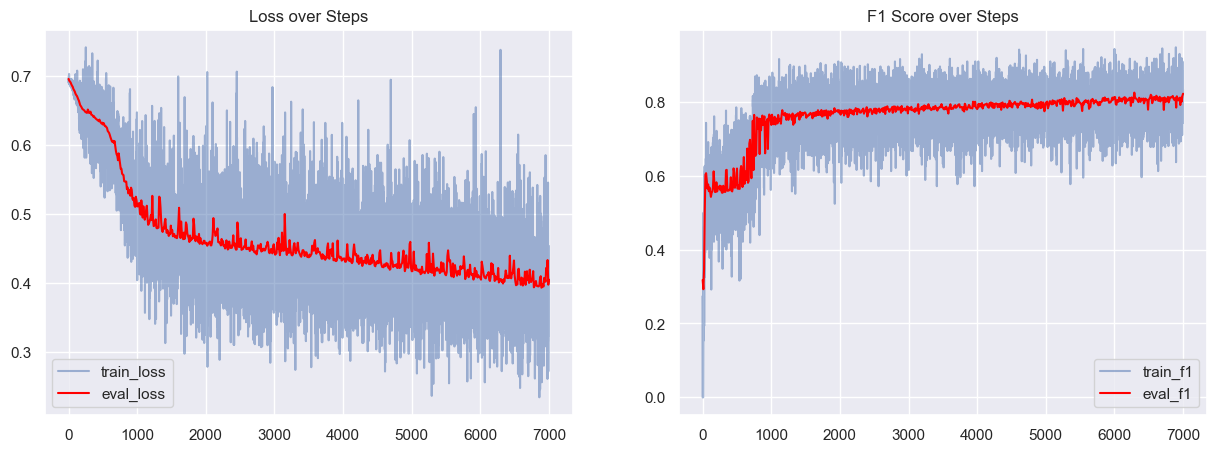

(0.406569442987442, 0.7997870074547391)

In [14]:
# Настройка функции потерь и оптимизатора
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Запуск обучения
epochs = 75
model = train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, num_epochs=epochs, eval_freq=10)

# Оценка на тестовой выборке
evaluate(model, test_dataloader, loss_function, device)

In [15]:
# Сбор предсказаний и истинных меток на тестовой выборке
preds, targets = get_predictions_and_labels(model, test_dataloader, device)

# Вывод classification_report
print(classification_report(targets, preds, target_names=["Class 0", "Class 1"]))

              precision    recall  f1-score   support

     Class 0       0.77      0.89      0.82       981
     Class 1       0.87      0.74      0.80      1019

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000



### Шаг 6
<details>
  <summary>Формулировка</summary>

6. Улучшите архитектуру модели из пункта 3 и добейтесь увеличения качества - **3 балла**
    - Попробуйте добавить слои `BatchNorm1d` и `Dropout` - поэкспериментируйте с их "расположением" в сети, напишите свои выводы о целесообразности их добавления в модель, оптимальном расположении, влиянии на качество/сходимость обучения. При использовании слоя `Dropout` - определите экспериментально или обоснуйте теоретически оптимальное значение параметра `p`.
    - Обучите улучшенную модель и проверьте ее качество (при необходимости измените гиперпараметры обучения - `batch_size`, скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val и архитектуру модели)

</details>

In [20]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0.03):
        super(ImprovedMLP, self).__init__()
        layers = []
        previous_size = input_size

        for i, hidden_size in enumerate(hidden_sizes): 
            layers.append(nn.Linear(previous_size, hidden_size))        # Линейный слой
            layers.append(nn.BatchNorm1d(hidden_size))                  # BatchNorm1d
            if i == 0:                   # Добавляем Dropout только после первого слоя
                layers.append(nn.Dropout(p=dropout_prob))
            layers.append(nn.ReLU())
            previous_size = hidden_size                                 

        # Выходной слой
        layers.append(nn.Linear(previous_size, 1))
        layers.append(nn.Sigmoid())  # Для бинарной классификации

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [21]:
input_size = X_train.shape[1]
hidden_sizes = [32, 16, 8] 
dropout_prob = 0.03        
batch_size = 64                             

# Создаем DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Инициализация модели
model = ImprovedMLP(input_size=input_size, hidden_sizes=hidden_sizes, dropout_prob=dropout_prob)
model = model.to(device)
model

ImprovedMLP(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.03, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=16, out_features=8, bias=True)
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=8, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

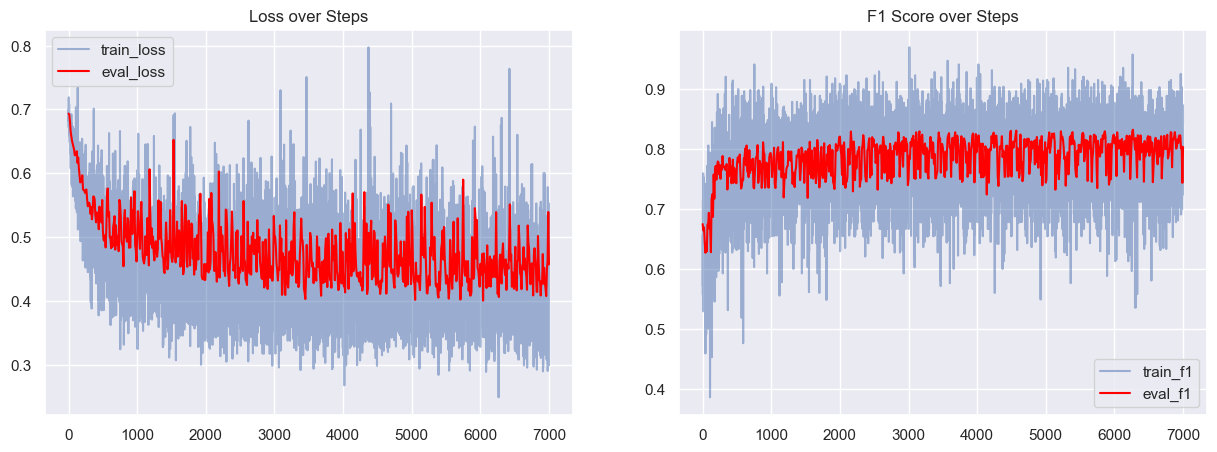

(0.4484835591316223, 0.7988533205924511)

In [22]:
# Настройка оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)

# Запуск обучения
epochs = 75
model = train_model(model, train_dataloader, val_dataloader, loss_function, optimizer, num_epochs=epochs, eval_freq=10)

# Оценка на тестовой выборке
evaluate(model, test_dataloader, loss_function, device)

In [23]:
# Оценка
# Сбор предсказаний и истинных меток на тестовой выборке
preds, targets = get_predictions_and_labels(model, test_dataloader, device)

# Вывод classification_report
print(classification_report(targets, preds, target_names=["Class 0", "Class 1"]))

              precision    recall  f1-score   support

     Class 0       0.80      0.76      0.78       981
     Class 1       0.78      0.82      0.80      1019

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



### Вывод

При попытке улучшить базовую модель (BaseMLP) путем добавления слоев `BatchNorm1d` и `Dropout`, а также экспериментирования с их расположением и гиперпараметрами, результаты оказались хуже или сопоставимы с базовой моделью.

Это новые эксперименты, но я так и не поняла пока что как улучшить... буду пробоавать позже еще